
# Name : **Shravanthi Balasubramanian**
# School :SCDS
# Email ID : *shravanthi.b-26@scds.saiuniversity.edu.in

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os


zip_path = '/content/drive/MyDrive/Car_Dataset.zip'
extract_path = '/content/Car_Dataset'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: /content/Car_Dataset


In [ ]:
import shutil

source_dir = '/content/Car_Dataset/Car_Dataset'
train_dir = '/content/splits/train'
test_dir = '/content/splits/test'

if os.path.exists(source_dir):
    print("Source directory exists:", os.listdir(source_dir))
else:
    print("Source directory does not exist:", source_dir)

print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        #retrieves like all the files in the current class dir
        all_files = os.listdir(class_path)

        #split files into train and test
        train_files, test_files = train_test_split(all_files, test_size=0.25, random_state=42)

        #move to train directory
        for file in train_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(train_dir, class_name, file)
            if not os.path.exists(dst):
                shutil.move(src, dst)

      #move to test dir
        for file in test_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(test_dir, class_name, file)
            if not os.path.exists(dst):
                shutil.move(src, dst)

Source directory exists: ['Audi', 'Mahindra Scorpio', 'Swift', 'Rolls Royce', 'Toyota Innova', 'Tata Safari', 'Hyundai Creta']
Train directory exists: False
Test directory exists: False


In [ ]:
def prepare_data(source_dir):
    file_paths, labels = [], []
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_folder = os.path.join(source_dir, class_name)
        if os.path.isdir(class_folder):
            for file in os.listdir(class_folder):
                file_paths.append(os.path.join(class_folder, file))
                labels.append(class_name)
    return file_paths, labels, classes

file_paths, labels, classes = prepare_data(source_dir)
num_classes = len(classes)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

#train datagen
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

#validation data gen
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

#testing data gen
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode= 'categorical',
    shuffle=False
)

#num of classes
num_classes = len(train_generator.class_indices)



Found 2811 images belonging to 7 classes.
Found 309 images belonging to 7 classes.
Found 1045 images belonging to 7 classes.


In [ ]:
num_classes = len(train_generator.class_indices)

base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)



171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpoint = ModelCheckpoint('/content/drive/MyDrive/ResNet101V2_TL.keras',
                             monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

#callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/ResNet101V2_TL.keras',
                             monitor='val_accuracy', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy', patience=3,
                           restore_best_weights=True, verbose=1)

#train model using generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)


#save
model.save('/content/drive/MyDrive/ResNet101V2_TL_final.keras')
print("Model training complete. Best model saved.")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4580 - loss: 1.5875
Epoch 1: val_accuracy improved from -inf to 0.78964, saving model to /content/drive/MyDrive/ResNet101V2_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 71s 538ms/step - accuracy: 0.4598 - loss: 1.5824 - val_accuracy: 0.7896 - val_loss: 0.6953
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8411 - loss: 0.5050
Epoch 2: val_accuracy improved from 0.78964 to 0.85113, saving model to /content/drive/MyDrive/ResNet101V2_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - accuracy: 0.8411 - loss: 0.5051 - val_accuracy: 0.8511 - val_loss: 0.5189
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8751 - loss: 0.3887
Epoch 3: val_accuracy improved from 0.85113 to 0.87379, saving model to /content/drive/MyDrive/ResNet101V2_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.8752 - loss: 0.3885 - val_accuracy: 0.8738 - val_loss: 0.4486
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - 

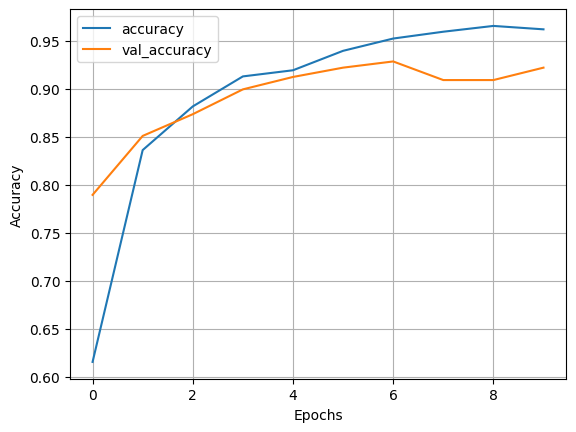

In [ ]:
#plot results
def plot_history(history):
    metrics = ['accuracy', 'val_accuracy']
    progress = {k: v for k, v in history.history.items() if k in metrics}
    pd.DataFrame(progress).plot()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

plot_history(history)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 295ms/step


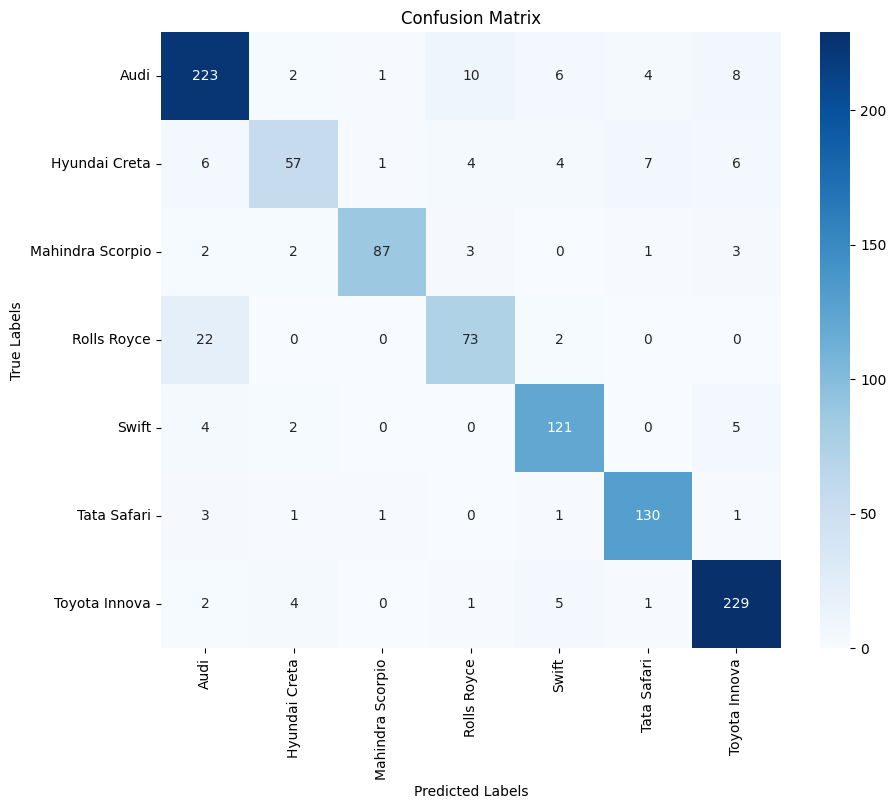

                  precision    recall  f1-score   support

            Audi       0.85      0.88      0.86       254
   Hyundai Creta       0.84      0.67      0.75        85
Mahindra Scorpio       0.97      0.89      0.93        98
     Rolls Royce       0.80      0.75      0.78        97
           Swift       0.87      0.92      0.89       132
     Tata Safari       0.91      0.95      0.93       137
   Toyota Innova       0.91      0.95      0.93       242

        accuracy                           0.88      1045
       macro avg       0.88      0.86      0.87      1045
    weighted avg       0.88      0.88      0.88      1045



In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#best saved model
model = load_model('/content/drive/MyDrive/ResNet101V2_TL.keras')

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

#confusion mat
conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

#classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)
